In [114]:
%matplotlib inline

In [115]:
import numpy as np
import math
import random
import scipy.sparse.linalg as linalg
import networkx as nx
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

np.set_printoptions(linewidth=200, suppress=True)

### Generating, plotting, etc.

In [116]:
# graph laplacian
def graph_laplacian(A):
    k = np.sum(A, axis=0)
    L = np.diag(k) - A
    return L

# stochastic block model
class StochasticBlockModelGenerator:

    def __init__(self, block_sizes, link_probs):
        self.block_sizes = block_sizes
        self.link_probs = link_probs

    def generate(self):
        n = sum(self.block_sizes)
        block_count = len(self.block_sizes)
        
        # randomly assign nodes to blocks
        indices = np.random.permutation(range(n))
        block_indices = []
        i = 0
        for size in self.block_sizes:
            block_indices.append(indices[i:(i + size)])
            i += size
        
        # initialize adjacency matrix with all zeros
        A = np.zeros((n, n))

        for i in range(block_count):
            for j in range(i, block_count):
                block = np.random.rand(self.block_sizes[i], self.block_sizes[j])                
                block[block > self.link_probs[i, j]] = -1
                block[block != -1] = 1
                block[block == -1] = 0
                if i == j: # take only upper triangular block
                    block = np.triu(block, k=1)
                A[np.ix_(block_indices[i], block_indices[j])] = block

        A = A + A.T
        A[A == 2] = 1
        return A

def fcounter():
    i = 1
    while True:
        yield i
        i += 1
fc = fcounter()
    
def plot_communities(A, s):
    indices = np.argsort(s)
    
    plt.figure(next(fc))
    plt.spy(A)
    plt.title("Adjacency Matrix")

    A_sorted = A[:, indices][indices]

    plt.figure(next(fc))
    plt.spy(A_sorted)
    plt.title("Adjacency Matrix Sorted")
    
    plt.draw()

def plot_eigenvector(v, l):
    plt.figure(next(fc))
    plt.plot(range(len(v)), sorted(v), color='black')
    plt.title("Eigenvector sorted: $\lambda$=%f"%l)
    
    plt.draw()

In [117]:
# plots the network
def plot_network(A):
    G = nx.from_numpy_matrix(A)
    G = nx.convert_node_labels_to_integers(G, first_label=1)
    
    pos = {1: (0, 0), 2: (15, -15), 3: (30, 0),
           4: (15, 15), 5: (30, 15), 6: (30, -15),
           7: (60, 0), 8: (90, 00), 9: (60, -15)}
    nx.draw(G, pos)
    nx.draw_networkx_labels(G, pos)

    plt.draw()

# Initialize the network and plot it

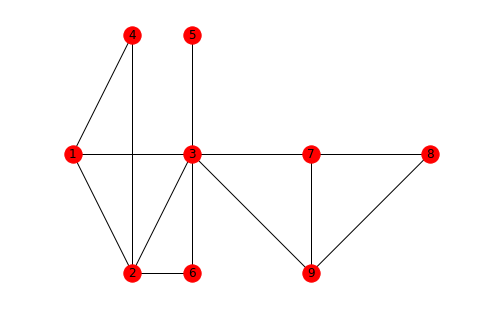

In [118]:
A = np.array([[0.,  1.,  1.,  1.,  0.,  0.,  0.,  0., 0.],
              [1.,  0.,  1.,  1.,  0.,  1.,  0.,  0., 0.],
              [1.,  1.,  0.,  0.,  1.,  1.,  1.,  0., 1.],
              [1.,  1.,  0.,  0.,  0.,  0.,  0.,  0., 0.],
              [0.,  0.,  1.,  0.,  0.,  0.,  0.,  0., 0.],
              [0.,  1.,  1.,  0.,  0.,  0.,  0.,  0., 0.],
              [0.,  0.,  1.,  0.,  0.,  0.,  0.,  1., 1,],
              [0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., 1.],
              [0.,  0.,  1.,  0.,  0.,  0.,  1.,  1., 0.]])
L = graph_laplacian(A)

plot_network(A)

# Kernighan-Lin

In [119]:
# random division vector
def divide_randomly(sizes):
    c = len(sizes)
    s = []
    for i in range(c):
        s.extend(sizes[i] * [i])
    random.shuffle(s)
    return np.array(s)

# bisection cut size
def cut_size(L, s):
    x = np.copy(s)
    x[x == 0] = -1
    R = np.dot(x, np.dot(L, x)) / 4
    return R

# swap nodes
def swap_nodes(s, i, j):
    x = np.copy(s) # copy first since we may want to keep the original division vector
    x[i] = (x[i] + 1) % 2 # move i to the other group
    x[j] = (x[j] + 1) % 2 # move j to the other group
    return x
    
# kernighan-lin bisection
def kernighan_lin(L, s, debug=True):
    n, n = L.shape
    R = cut_size(L, s)
    
    round = 0
    s_temp = np.copy(s)
    while True:
        if debug:
            print('----------------')
            print('round', round)       
        
        R_pass = {}
        s_pass = {}        
        all_swapped = False
        swapped = n * [False]
        counter = 0
        while not all_swapped:
            R_new = {}            
            all_swapped = True
            
            # iterate over all pairs
            for i in range(n):
                for j in range(i + 1, n):
                    if not swapped[i] and not swapped[j]:
                        if s_temp[i] != s_temp[j]: # if in different groups
                            x = swap_nodes(s_temp, i, j)
                            R_swap = cut_size(L, x)
                            R_new[(i, j)] = R_swap                            
                        
            if R_new:
                pair = min(R_new, key=R_new.get) # swap the pair with smallest R
                i = pair[0]
                j = pair[1]
                s_temp = swap_nodes(s_temp, i, j)
                swapped[i] = True
                swapped[j] = True                            
                R_swap = R_new[pair]
                R_pass[counter] = R_swap
                s_pass[counter] = np.copy(s_temp)
                counter += 1
                all_swapped = False
        
        counter = min(R_pass, key=R_pass.get) # pick the division with smallest R
        if R_pass[counter] < R:
            s_temp = s_pass[counter]
            s = np.copy(s_temp)
            R = R_pass[counter]
            print('Improved R: ', R)
        else:
            print('Converged')
            break
        round += 1
        
    return s

def print_division(L, s):
    print('*********************')
    print('Division vector:')
    print(s)
    print('Cut size R:', cut_size(L, s))

### Group sizes and initial division fixed

In [120]:
s = np.array([1, 0, 0, 0, 0, 1, 0, 0, 1])
s = kernighan_lin(L, s)
print_division(L, s)

----------------
round 0
Improved R:  2.0
----------------
round 1
Converged
*********************
Division vector:
[0 0 0 0 0 0 1 1 1]
Cut size R: 2.0


### Group sizes and initial division fixed (captured in a local minimum)

In [121]:
s = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1])
s = kernighan_lin(L, s)
print_division(L, s)

----------------
round 0
Improved R:  3.0
----------------
round 1
Converged
*********************
Division vector:
[1 1 0 1 0 0 0 0 0]
Cut size R: 3.0


### Equal group sizes and random initial division

In [122]:
s = divide_randomly([5, 4])
print(s)
s = kernighan_lin(L, s)
print_division(L, s)

[0 0 1 1 0 1 1 0 0]
----------------
round 0
Improved R:  3.0
----------------
round 1
Converged
*********************
Division vector:
[1 1 0 1 0 1 0 0 0]
Cut size R: 3.0


# Spectral Clustering

In [123]:
# normalized graph laplacian
def normalized_graph_laplacian(L):
    k = np.diag(L)
    k_inverse_square_root = [1 / math.sqrt(a) for a in k]
    D_inverse_square_root = np.diag(k_inverse_square_root)    
    Ln = np.dot(np.dot(D_inverse_square_root, L), D_inverse_square_root)
    return Ln, D_inverse_square_root

# spectral clustering
def spectral_clustering(M):
    l, v = linalg.eigs(M, k=2, which='SR') # second smallest eigenvalue
    l2 = l[1].real    
    v2 = v[:, 1]
    v2 = [a.real for a in v2]
    return l2, v2

# print function
def print_spectral_solution(l2, v2):
    print('Algebraic connectivity lambda_2: ', l2)
    print('Eigenvector v2:')
    print(v2)

### Graph Laplacian

In [124]:
print('Graph Laplacian:')
print(L)

Graph Laplacian:
[[ 3. -1. -1. -1.  0.  0.  0.  0.  0.]
 [-1.  4. -1. -1.  0. -1.  0.  0.  0.]
 [-1. -1.  6.  0. -1. -1. -1.  0. -1.]
 [-1. -1.  0.  2.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  1.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  2.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  3. -1. -1.]
 [ 0.  0.  0.  0.  0.  0. -1.  2. -1.]
 [ 0.  0. -1.  0.  0.  0. -1. -1.  3.]]


### Second smallest eigenvalue and the corresponding eigenvector

In [125]:
l2, v2 = spectral_clustering(L)
print_spectral_solution(l2, v2)

Algebraic connectivity lambda_2:  0.610286417667
Eigenvector v2:
[0.30689377312491112, 0.2871326783292914, 0.018810302718462332, 0.42744523692218844, 0.048266992917895143, 0.22014822689881533, -0.38052976361071295, -0.54763768369013766, -0.38052976361071239]


### Normalized Graph Laplacian

In [126]:
Ln, D_inverse_square_root = normalized_graph_laplacian(L)
print(Ln)

[[ 1.         -0.28867513 -0.23570226 -0.40824829  0.          0.          0.          0.          0.        ]
 [-0.28867513  1.         -0.20412415 -0.35355339  0.         -0.35355339  0.          0.          0.        ]
 [-0.23570226 -0.20412415  1.          0.         -0.40824829 -0.28867513 -0.23570226  0.         -0.23570226]
 [-0.40824829 -0.35355339  0.          1.          0.          0.          0.          0.          0.        ]
 [ 0.          0.         -0.40824829  0.          1.          0.          0.          0.          0.        ]
 [ 0.         -0.35355339 -0.28867513  0.          0.          1.          0.          0.          0.        ]
 [ 0.          0.         -0.23570226  0.          0.          0.          1.         -0.40824829 -0.33333333]
 [ 0.          0.          0.          0.          0.          0.         -0.40824829  1.         -0.40824829]
 [ 0.          0.         -0.23570226  0.          0.          0.         -0.33333333 -0.40824829  1.        ]]


### Second smallest eigenvalue and the corresponding eigenvector

In [127]:
l2, v2 = spectral_clustering(Ln)
print_spectral_solution(l2, v2)

s = np.dot(D_inverse_square_root, v2)
print('Division vector:')
print(s)

Algebraic connectivity lambda_2:  0.236597527379
Eigenvector v2:
[-0.33804664383389976, -0.37977513841021793, -0.011992947166310941, -0.35666344039390607, -0.0064135241289701396, -0.18041971099794396, 0.43008748056869567, 0.45999976418536898, 0.43008748056869522]
Division vector:
[-0.19517132 -0.18988757 -0.0048961  -0.25219914 -0.00641352 -0.127576    0.24831112  0.32526895  0.24831112]


### Stochastic Block Models

Improved R:  144.0
Improved R:  28.0
Converged
Improved R:  63.0
Improved R:  28.0
Converged
Improved R:  333.0
Improved R:  329.0
Improved R:  328.0
Converged
Improved R:  328.0
Improved R:  327.0
Converged
Improved R:  28.0
Converged
Improved R:  28.0
Converged
Improved R:  28.0
Converged
Improved R:  28.0
Converged
Improved R:  28.0
Converged
Improved R:  97.0
Improved R:  28.0
Converged
Best cut size R:  28.0


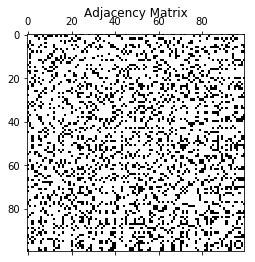

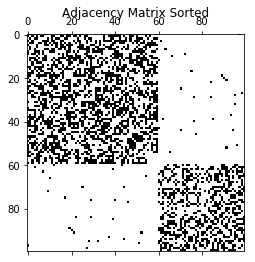

In [128]:
sizes = np.array([60, 40])
probs = np.array([[0.5, 0.01], [0.01, 0.4]])
sbm = StochasticBlockModelGenerator(sizes, probs)
A = sbm.generate()
L = graph_laplacian(A)

R = {}
divisions = {}
for i in range(10):
    s = divide_randomly([60, 40])
    s = kernighan_lin(L, s, debug=False)
    R[i] = cut_size(L, s)
    divisions[i] = np.copy(s)
index = min(R, key=R.get)

print('Best cut size R: ', R[index])
plot_communities(A, divisions[index])

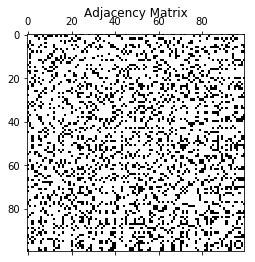

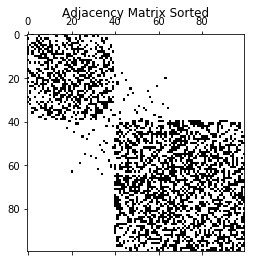

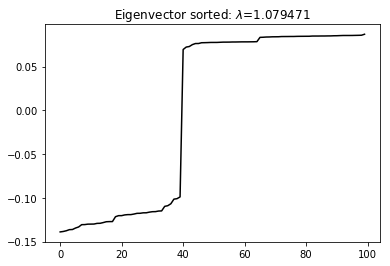

In [129]:
l2, v2 = spectral_clustering(L)
plot_communities(A, v2)
plot_eigenvector(v2, l2)

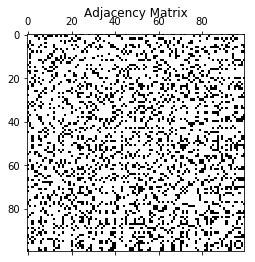

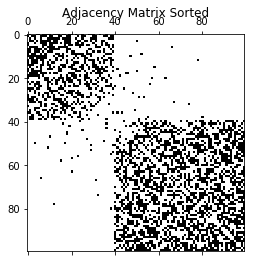

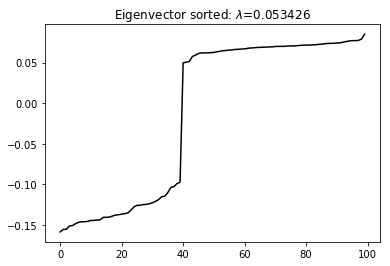

In [130]:
Ln, D_inverse_square_root = normalized_graph_laplacian(L)
l2, v2 = spectral_clustering(Ln)
plot_communities(A, v2)
plot_eigenvector(v2, l2)

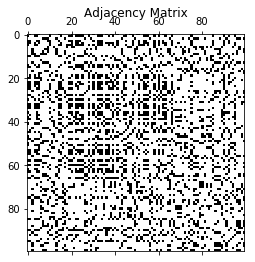

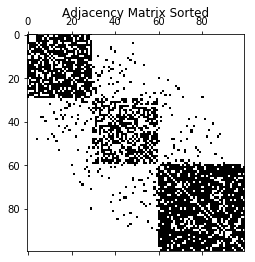

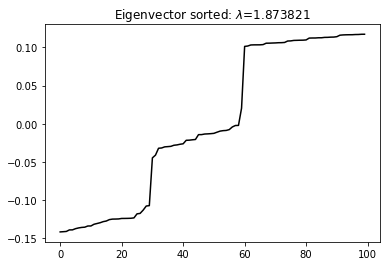

In [131]:
sizes = np.array([40, 30, 30])
probs = np.array([[0.8, 0.01, 0.05], [0.01, 0.7, 0.05], [0.05, 0.05, 0.6]])
sbm = StochasticBlockModelGenerator(sizes, probs)
A = sbm.generate()
L = graph_laplacian(A)

l2, v2 = spectral_clustering(L)
plot_communities(A, v2)
plot_eigenvector(v2, l2)

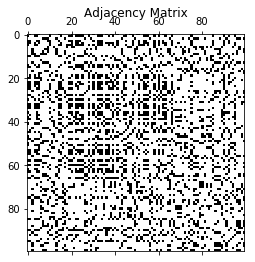

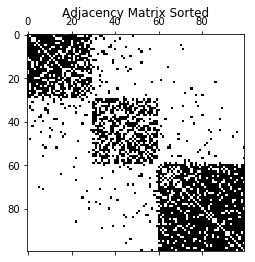

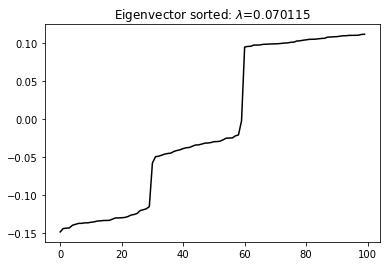

In [132]:
Ln, D_inverse_square_root = normalized_graph_laplacian(L)
l2, v2 = spectral_clustering(Ln)
plot_communities(A, v2)
plot_eigenvector(v2, l2)